In [110]:
import pandas as pd
import numpy as np 
import pymc as pm 
import arviz as az
import xarray as xr

import jax

import matplotlib.pyplot as plt
# Load the data
data = pd.read_csv('../data/nyc_regression_data.csv')
data

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
4,1.0,WHITE,M,45-64,OTHER STATE LAWS,V
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [144]:
data_m_f = data[(data["law_cat_cd"].isin(["M", "F"]))]
data_m_f

,precinct,perp_race,perp_sex,age_group,ofns_desc,law_cat_cd
0,1.0,WHITE,M,25-44,CRIMINAL MISCHIEF & RELATED OF,M
1,1.0,BLACK,M,25-44,FELONY ASSAULT,F
2,1.0,WHITE HISPANIC,M,45-64,CRIMINAL TRESPASS,M
3,1.0,BLACK,M,45-64,ASSAULT 3 & RELATED OFFENSES,M
5,1.0,WHITE HISPANIC,M,25-44,DANGEROUS DRUGS,M
...,...,...,...,...,...,...
63610,123.0,WHITE,M,18-24,DANGEROUS WEAPONS,F
63611,123.0,WHITE,M,25-44,ROBBERY,F
63612,123.0,BLACK,F,18-24,FELONY ASSAULT,F
63613,123.0,BLACK,F,45-64,FELONY ASSAULT,F


In [3]:
# data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")

/tmp/ipykernel_42078/2538464095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_m_f["perp_race"] = data_m_f["perp_race"].apply(lambda x: "BLACK" if "BLACK" in x else "NON BLACK")


# Number of crimes

In [145]:
data_grouped = data.groupby(["precinct"])["perp_race"].value_counts().reset_index(name="count")
data_grouped

,precinct,perp_race,count
0,1.0,BLACK,345
1,1.0,WHITE HISPANIC,234
2,1.0,WHITE,162
3,1.0,BLACK HISPANIC,66
4,1.0,ASIAN / PACIFIC ISLANDER,43
...,...,...,...
502,123.0,BLACK,42
503,123.0,ASIAN / PACIFIC ISLANDER,18
504,123.0,UNKNOWN,9
505,123.0,BLACK HISPANIC,8


In [146]:
precinct_ids, unique_precincts = pd.factorize(data_grouped['precinct'], sort=True)

In [147]:
## number of crimes with precinct only

with pm.Model(coords={'precincts': unique_precincts}) as  precinct_count_model:
    # alpha = pm.Normal('alpha', mu=5, sigma=1.5)
    beta_p = pm.Normal('beta_p', mu=5, sigma=1.5, dims='precincts')
    precinct_id = pm.Data('precinct_id', precinct_ids)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(beta_p[precinct_id]))
    
    crime = pm.Poisson('crime', lambda_, observed=data_grouped["count"])

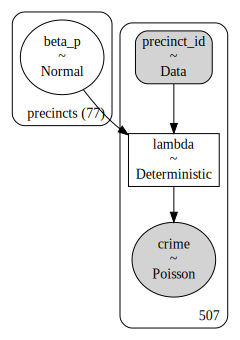

In [148]:
pm.model_to_graphviz(precinct_count_model)

In [149]:
with precinct_count_model:

    precinct_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, idata_kwargs=dict(log_likelihood=True), cores=4,nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 2000/2000 [00:08<00:00, 229.27it/s, 7 steps of size 5.24e-01. acc. prob=0.83]


In [150]:
az.summary(precinct_count_trace, var_names=["beta_p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_p[1.0],4.806,0.035,4.743,4.875,0.000,0.000,5813.0,2987.0,1.0
beta_p[5.0],4.922,0.032,4.863,4.984,0.000,0.000,5245.0,3169.0,1.0
beta_p[6.0],4.374,0.042,4.300,4.454,0.001,0.000,6279.0,3275.0,1.0
beta_p[7.0],4.491,0.040,4.416,4.566,0.001,0.000,5220.0,3215.0,1.0
beta_p[9.0],4.444,0.044,4.362,4.528,0.001,0.000,6237.0,3006.0,1.0
...,...,...,...,...,...,...,...,...,...
beta_p[115.0],5.198,0.029,5.143,5.252,0.000,0.000,7029.0,2693.0,1.0
beta_p[120.0],5.290,0.026,5.242,5.339,0.000,0.000,6143.0,3183.0,1.0
beta_p[121.0],4.731,0.037,4.658,4.795,0.001,0.000,4943.0,2696.0,1.0
beta_p[122.0],4.052,0.051,3.960,4.149,0.001,0.000,6235.0,3017.0,1.0


array([[<Axes: title={'center': 'beta_p'}>,
        <Axes: title={'center': 'beta_p'}>]], dtype=object)

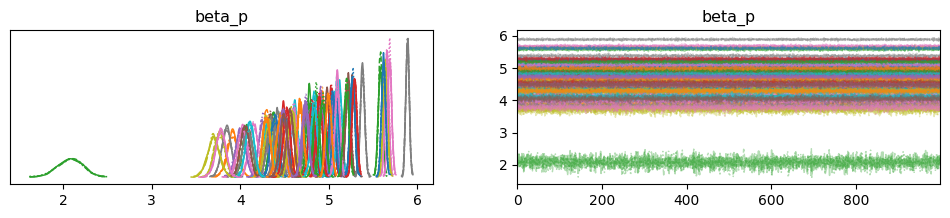

In [151]:
az.plot_trace(precinct_count_trace, var_names=["beta_p"])

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

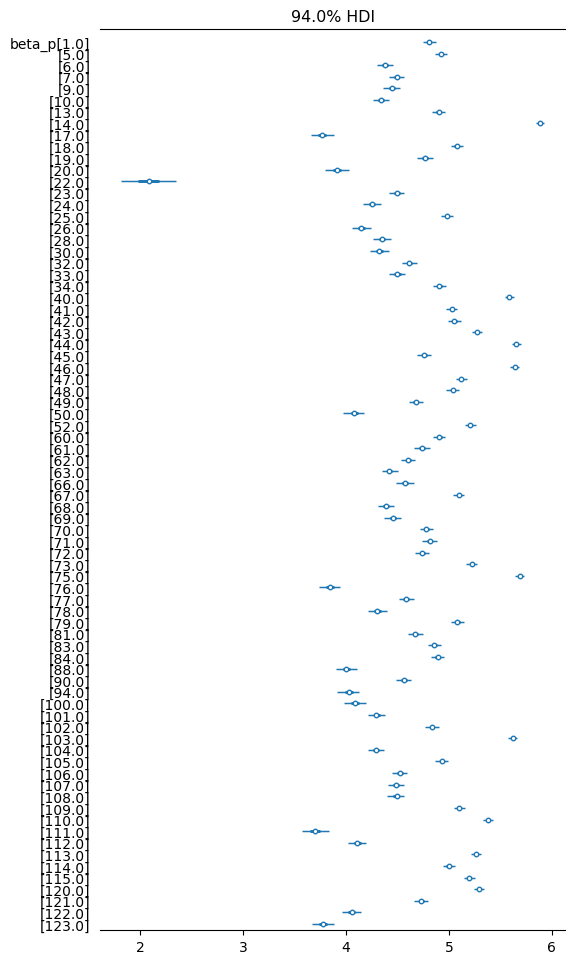

In [152]:
az.plot_forest(precinct_count_trace, combined=True, var_names=["beta_p"], textsize=10)

## Precinct and Race

In [153]:
race_ids, unique_race = pd.factorize(data_grouped['perp_race'], sort=True)


In [154]:
with pm.Model(coords={'precincts': unique_precincts, 'race': unique_race}) as  precinct_race_count_model:
    beta_p = pm.Normal('beta_p', mu=0, sigma=1.5, dims="precincts")
    beta_r = pm.Normal('beta_r', mu=0, sigma=1.5, dims="race")
    precinct_id = pm.Data('precinct_id', precinct_ids)
    race_id = pm.Data('race_id', race_ids)
    
    lambda_ = pm.Deterministic("lambda", pm.math.exp(beta_p[precinct_id]+ beta_r[race_id]))
    
    crime = pm.Poisson('crime', lambda_, observed=data_grouped["count"])

In [157]:
with precinct_race_count_model:
    prior_checks = pm.sample_prior_predictive(samples=100)

Sampling: [beta_p, beta_r, crime]


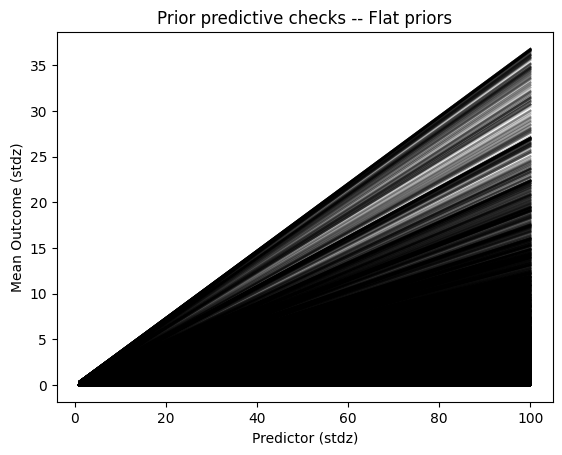

In [163]:
prior = prior_checks["prior"]

from scipy.stats import poisson

pois = poisson(mu=np.exp(prior["beta_p"] + prior["beta_r"]).stack(sample=("chain", "draw")))

x = xr.DataArray(np.linspace(1, 100, 100), dims=["plot_dim"])


_, ax = plt.subplots()

ax.plot(x, np.outer(x,pois.pmf(x)), c="k", alpha=0.2)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");


In [101]:
with precinct_race_count_model:
    precinct_race_count_trace = pm.sample(1000, tune=1000, return_inferencedata=True, cores=4, idata_kwargs=dict(log_likelihood=True), nuts_sampler="numpyro")

/home/thejarmanitor/miniconda3/envs/algfair-exam/lib/python3.10/site-packages/pymc/sampling/jax.py:470: UserWarning: There are not enough devices to run parallel chains: expected 8 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(8)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
warmup:  16%|█▋        | 326/2000 [00:04<00:23, 69.88it/s, 31 steps of size 1.51e-02. acc. prob=0.78] 


KeyboardInterrupt: 

In [100]:
az.summary(precinct_race_count_trace, var_names=["beta_p", "beta_r"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_p[1.0],-0.180,0.746,-0.981,1.151,0.352,0.267,5.0,13.0,2.18
beta_p[5.0],-0.245,0.746,-1.056,1.061,0.352,0.267,5.0,13.0,2.18
beta_p[6.0],-0.593,0.746,-1.413,0.736,0.352,0.267,5.0,13.0,2.17
beta_p[7.0],-0.491,0.745,-1.298,0.831,0.352,0.267,5.0,13.0,2.16
beta_p[9.0],-0.650,0.747,-1.463,0.684,0.353,0.268,5.0,13.0,2.17
...,...,...,...,...,...,...,...,...,...
beta_p[121.0],-0.194,0.746,-1.007,1.113,0.352,0.267,5.0,13.0,2.18
beta_p[122.0],-0.869,0.747,-1.690,0.476,0.352,0.267,5.0,12.0,2.17
beta_p[123.0],-1.145,0.747,-2.003,0.172,0.352,0.268,5.0,12.0,2.15
beta_r[BLACK],6.294,0.745,5.007,7.084,0.352,0.268,5.0,14.0,2.20


array([[<Axes: title={'center': 'beta_p'}>,
        <Axes: title={'center': 'beta_p'}>],
       [<Axes: title={'center': 'beta_r'}>,
        <Axes: title={'center': 'beta_r'}>]], dtype=object)

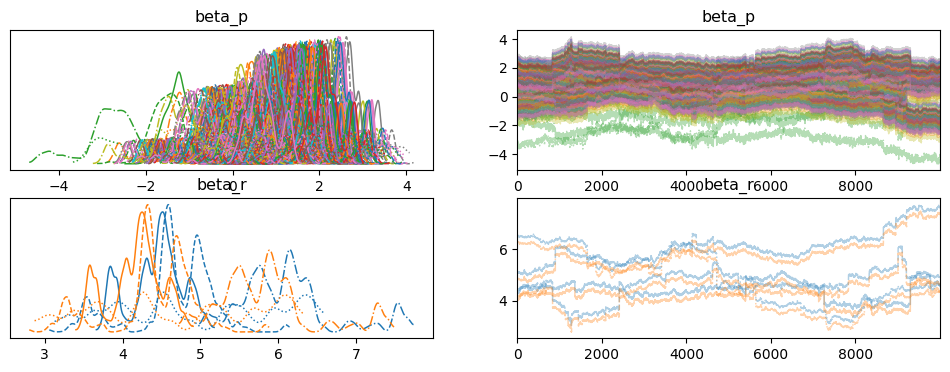

In [95]:
az.plot_trace(precinct_race_count_trace, var_names=["beta_p", "beta_r"])

Text(0.5, 1.0, 'Precinct & race City Crime Count')

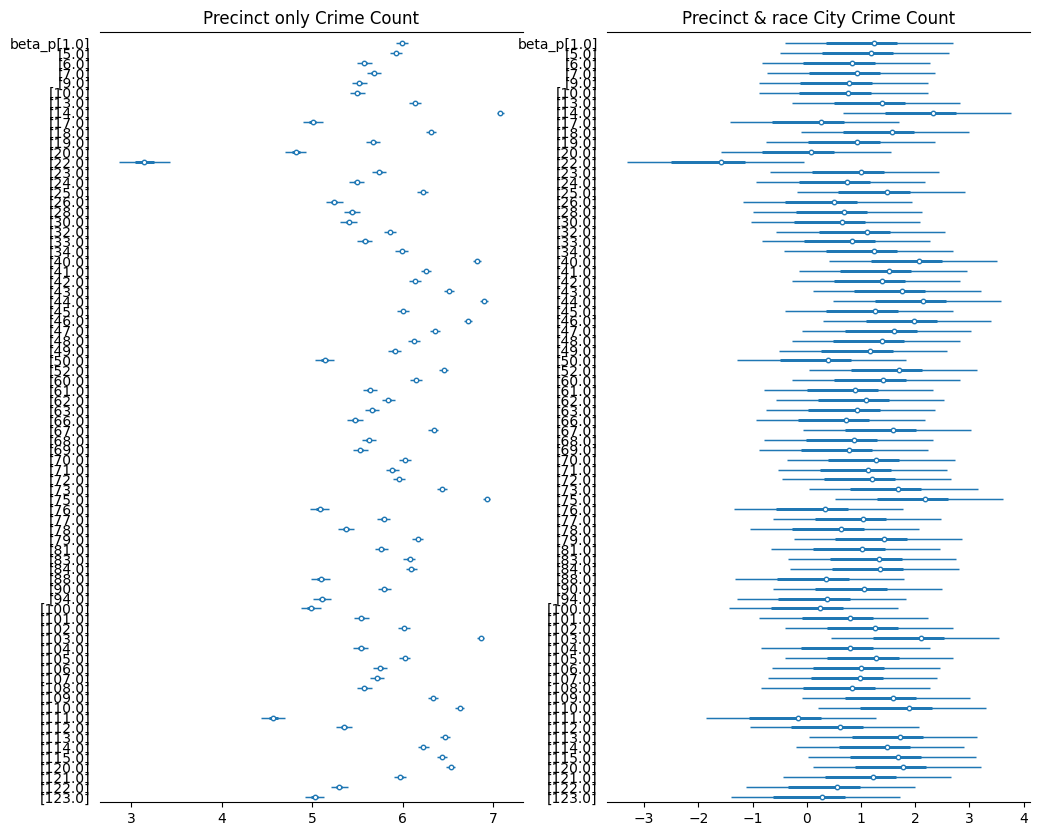

In [96]:
_, ax = plt.subplots(1, 2, figsize=(12, 10))

az.plot_forest(precinct_count_trace, combined=True, var_names=["beta_p"], ax=ax[0], textsize=10)
ax[0].set_title("Precinct only Crime Count")
az.plot_forest(precinct_race_count_trace, combined=True, var_names=["beta_p"], ax=ax[1], textsize=10)
ax[1].set_title("Precinct & race City Crime Count")

In [ ]:
#